# This code is to check the correlation of theta skipping at lower angular speed and degree of phase precession at higher angular speed. Experimental data is based on Lomi et al, 2023. This code is written by Zilong Ji, 2024.

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from numpy import deg2rad
from scipy.optimize import curve_fit
from scipy.ndimage import convolve1d
from scipy.stats import mannwhitneyu, wilcoxon, pearsonr, spearmanr

import sys
sys.path.append('/home/zilong/Desktop/HDPhasePrecession/CircularLinearReg')
from core import cl_corr
import HD_utils

%load_ext autoreload
%autoreload 2


In [2]:
def sinmodel(t, a, b, c, omega, t1, t2):
    return (a * (np.sin(2*np.pi*omega * t + np.pi/2) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2) 

def calculate_intrinsic_frequency(autocorrelogram):

    # Fit the model to the autocorrelogram data
    initial_guess = [1, 1, 0.1, 9, 1.0, 0.01]  # Initial guesses for a, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 6, 0, 0], [100, 100, 0.8, 12, 8, 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    #normalze autocorr to 0-1
    lags = autocorrelogram[1, :] / 1000.  # Convert lags to seconds

    params, _ = curve_fit(sinmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    # Extract the intrinsic frequency (omega)
    intrinsic_frequency = params[3]
    print(f"Intrinsic Theta Frequency: {intrinsic_frequency:.2f} Hz")
    
    return intrinsic_frequency, params

def skipmodel(t, a1, a2, b, c, omega, t1, t2):
    return (a1 * (np.cos(omega * t) + 1) + a2 * (np.cos(0.5*omega * t) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2)

def calculate_skipping_index(autocorrelogram):
    # Fit the model to the autocorrelogram data
    initial_guess = [0.5, 0.5, 0.1, 0.1, 2 * 8 * np.pi, 0.01, 0.01]  # Initial guesses for a1, a2, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 0, 12*np.pi, 0, 0], [100, 100, 100, 0.8, 24*np.pi, 8., 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    lags = autocorrelogram[1, :] / 1000  # Convert lags to seconds

    params, covariance = curve_fit(skipmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    omega = params[4] #freq

    # Calculate p1 and p2
    p1 = skipmodel(2 * np.pi / omega, *params)
    p2 = skipmodel(4 * np.pi / omega, *params)

    # Calculate the theta cycle skipping index
    TS = (p2 - p1) / max(p1, p2)
    
    print(f"Omega: {omega / (2 * np.pi):.2f} Hz")
    print(f"Theta Cycle Skipping Index: {TS:.2f}")
    
    return omega, TS, params  # Return frequency in Hz and the TS index

def compute_autocorrelation(spike_array, bin_size=0.02, max_lag=0.5):
    # Number of bins for the max_lag
    max_lag_bins = int(max_lag / bin_size)
    autocorr = np.correlate(spike_array, spike_array, mode='full')
    mid_point = len(autocorr) // 2
    autocorr = autocorr[mid_point - max_lag_bins: mid_point + max_lag_bins + 1]
    
    # Normalize the autocorrelation values
    lags = np.arange(-max_lag_bins, max_lag_bins + 1) * bin_size  # Lags in seconds
    
    idx_range = np.where((lags >= 0.05) & (lags <= 0.25))[0]
    max_value = np.max(autocorr[idx_range])
    autocorr = autocorr / max_value
    autocorr = np.clip(autocorr, a_min=None, a_max=1)  # Clip values above 1
    
    lags_ms = lags * 1000  # Convert to ms
    
    # Convert autocorr, lags into a 2*n array
    return np.array([autocorr, lags_ms])

def get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=1/2/np.pi, bootstrap_iter=1000, return_pval=True)
    

    return pval, circ_lin_corr

def plot_autocorrelogram(ax, autocorrelogram):
    
    autocorr = autocorrelogram[0, :]

    ax.plot(autocorrelogram[1,:], autocorr, color='k', label='Autocorrelogram')
    #fill between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorr, color='k', alpha=1.0)

    intrinsic_frequency, params = calculate_intrinsic_frequency(autocorrelogram)

    #plot the fitted curve
    t = autocorrelogram[1,:]/1000
    #get the predicted y one by one
    y = []
    for i in range(len(t)):
        y.append(sinmodel(t[i], *params))
        
    ax.plot(t*1000, sinmodel(t, *params), color='red', label='Fitted curve', linewidth=1)
    
    ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
    
    ax.set_xticks([-500, 0, 500])   
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.set_xlabel('Lag (ms)', fontsize=10)
    ax.set_ylabel('Autocorrelation', fontsize=10)
     
    return ax, intrinsic_frequency

def plot_thetaskipping(ax, autocorrelogram):
    
    labelsize = 10
    ticksize = 8
    
    autocorr = autocorrelogram[0, :]

    ax.plot(autocorrelogram[1,:], autocorr, color='k', label='Autocorrelogram')
    #fill between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorr, color='k', alpha=1.0)

    omega, TS, params = calculate_skipping_index(autocorrelogram)

    #plot the fitted curve
    t = autocorrelogram[1,:]/1000
        
    ax.plot(t*1000, skipmodel(t, *params), color='red', label='Fitted curve', linewidth=1)
    
    #ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
    
    ax.set_xticks([-500, 0, 500])   
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.set_xlabel('Lag (ms)', fontsize=labelsize)
    #ax.set_ylabel('Autocorrelation', fontsize=labelsize)
    ax.set_title('TS: ' + str(np.round(TS, 2)), fontsize=labelsize)
    
    #set x and y tick fontsize to 8
    ax.tick_params(axis='x', which='major', labelsize=ticksize)
    ax.tick_params(axis='y', which='major', labelsize=ticksize)
    
    
    return ax, TS

def plot_head_direction_tuning(ax, ppoh, psph, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0°', '90°', '180°', '270°'])
    
    #remove yticks
    ax.set_yticks([])
    
    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    #ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()
    #set x and y tick as 8 pt
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    return ax


def compute_spike_array(ppoh, pot, spike_times, timestamps, config):
    """
    Compute the spike array from spike times and timestamps.
    """
    
    speed_threshold = config['speed_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)   
    #make the dimension the same as timestamps by add 0 at the end
    angular_speed = np.append(angular_speed, 0)
    
    #get index of timestamps when speed is below speed_threshold
    lowspeed_idx = np.where(angular_speed < speed_threshold)[0]
    
    
    # Assume t is sorted. If not, you must sort it first.
    indices = np.searchsorted(timestamps, spike_times, side='right')

    # Ensure no out-of-bounds indices
    indices = np.clip(indices, 0, len(timestamps) - 1)

    # Adjust indices to always refer to the nearest timestamp
    # If the index points to the start of the array, no need to adjust
    # If not, check if the previous index is closer
    prev_close = (indices > 0) & (np.abs(timestamps[indices - 1] - spike_times) < np.abs(timestamps[indices] - spike_times))
    indices[prev_close] -= 1

    spike_array = np.zeros_like(timestamps)
    np.add.at(spike_array, indices, 1) #very fast!
    
    #set spike_array to 0 when speed is above lowspeed_idx
    for i in range(len(lowspeed_idx)):
        #if i is not in lowspeed_idx, set spike_array[i] to 0
        if i not in lowspeed_idx:
            spike_array[i] = 0
    
    
    return spike_array

def plot_phaseprecession(ax, ppoh, pot, pspt, psph, hd_mean, spike_phase, config, addfitline=True):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    alpha = 0.4
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=0, bootstrap_iter=3000, return_pval=True)

    #if len(psph_combined)>200 then random sample 200 points from it, otherwise plot all points
    if len(psph_combined) > np.inf:
        idx = np.random.choice(len(psph_combined), 200, replace=False)
        psph_combined = psph_combined[idx]
        spike_phase_combined = spike_phase_combined[idx]
         
        ax.scatter(psph_combined, spike_phase_combined, s=0.2, color='black', alpha=alpha)
        ax.scatter(psph_combined, [spike_phase_combined[i] + 2 * np.pi for i in range(len(spike_phase_combined))], s=0.2, color='black', alpha=alpha)
    else:
        ax.scatter(psph_combined, spike_phase_combined, s=0.2, color='black', alpha=alpha)
        ax.scatter(psph_combined, [spike_phase_combined[i] + 2 * np.pi for i in range(len(spike_phase_combined))], s=0.2, color='black', alpha=alpha)
        

    if addfitline:
        # Plot the circular-linear regression
        x = np.linspace(0, 2 * np.pi, 100)
        y = 2 * np.pi * slope * x + phi0
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 4*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #substrac intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)   
    
    ax.set_title('CL Corr: ' + str(np.round(circ_lin_corr, 2)), fontsize=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
    
    ax.set_ylim(0, 4*np.pi)
    ax.set_yticks([0,  2*np.pi,  4*np.pi])
    ax.set_yticklabels(["$0$", "$2\pi$", "$4\pi$"])
    
    #set tick size as 8 using one line
    ax.tick_params(axis='both', labelsize=8)
    

    return ax, pval, circ_lin_corr

## Now calculate theta skipping index and analyse the relationship between skipping index and and the degree of phase precession

In [4]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'
output_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/all/'
output_skip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/skip/'
output_nonskip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/nonskip/'
output_nontheta_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/nontheta/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 40,  #0.8,0.8,40 gives 43% pp cells
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'IFR_window':0.2
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir, output_nontheta_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

theta_ppp = []
theta_nonskip_ppp = []
theta_skip_ppp = []

theta_clr = []
theta_nonskip_clr = []
theta_skip_clr = []

theta_TS = []
theta_nonskip_TS = []
theta_skip_TS = []

theta_TS_1 = []
theta_nonskip_TS_1 = []
theta_skip_TS_1 = []

theta_tw = []
theta_nonskip_tw = []
theta_skip_tw = []

theta_ATI_widthshift = []
theta_nonskip_ATI_widthshift = []
theta_skip_ATI_widthshift = []
nontheta_ATI_widthshift = []

theta_ATI_cwccw = []
theta_nonskip_ATI_cwccw = []
theta_skip_ATI_cwccw = []
nontheta_ATI_cwccw = []

total_hd_cells = 0

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    global_freq = data_dict['global_freq'][0][0]
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        hd_pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                        hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                        peak_fr = cell_data['peak_fr'][0][0]
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        ATI_widthshift = cell_data['ATI_widthshift'][0][0]
                        ATI_cwccw = cell_data['ATI_cwccw'][0][0]
                        cell_type = cell_data['cell_type']
                        
                        #store matname for each cell
                        matnames[cell_name] = [ratname, file_path]
                        
                        #if hd_pval < 0.05: #select only head direction tuned cells
                        if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                            try:
                                #get results for phase precession against tuning angle
                                pval, clr = get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                                
                                fig = plt.figure(figsize=(4.2, 1.5), dpi=300)
                                gs=fig.add_gridspec(1, 3, width_ratios=[2, 2, 1.5])
                                
                                ax0 = fig.add_subplot(gs[0], projection='polar')
                                #head direction tuning curve
                                ax0 = plot_head_direction_tuning(ax0, ppoh, psph, config)
                                
                                ax1 = fig.add_subplot(gs[1])
                                
                                spike_array = compute_spike_array(ppoh, pot, pspt, pot_interp, config)
                                #plot theta skipping
                                autocorrelogram2 = compute_autocorrelation(spike_array, bin_size=new_interval, max_lag=0.5)
                                ax1, TS_1 = plot_thetaskipping(ax1, autocorrelogram)
                                
                                ax1, TS = plot_thetaskipping(ax1, autocorrelogram2)
                                
                                ax2 = fig.add_subplot(gs[2])
                                #plot phase precession
                                ax2, pval, clr = plot_phaseprecession(ax2, ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                            
                                output_path = os.path.join(output_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                
                                plt.tight_layout()
                                plt.savefig(output_path)
                            
                                #save fig according to cell type in different folders
                                if cell_type == ' Strong ThetaxHD ' or cell_type == ' Strong ThetaxHD  & skip': #This is a theta modulated HD cell
                                    #if pval<0.05 and clr<0: 
                                    if True:
                                    
                                        theta_ppp.append(pval)
                                        theta_clr.append(clr)
                                        theta_TS.append(TS)
                                        theta_TS_1.append(TS_1)
                                        theta_tw.append(tune_width)
                                        theta_ATI_widthshift.append(ATI_widthshift)
                                        theta_ATI_cwccw.append(ATI_cwccw)
                                        
                                        if cell_type == ' Strong ThetaxHD  & skip': #this is a theta skipping cell
                                            theta_skip_ppp.append(pval)
                                            theta_skip_clr.append(clr)
                                            theta_skip_TS.append(TS)
                                            theta_skip_TS_1.append(TS_1)
                                            theta_skip_tw.append(tune_width)
                                            theta_skip_ATI_widthshift.append(ATI_widthshift)
                                            theta_skip_ATI_cwccw.append(ATI_cwccw)
                                            output_skip_path = os.path.join(output_skip_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                            plt.savefig(output_skip_path)
                                        elif cell_type == ' Strong ThetaxHD ': #this is a theta modulated non-skipping cell
                                            theta_nonskip_ppp.append(pval)
                                            theta_nonskip_clr.append(clr)
                                            theta_nonskip_TS.append(TS)
                                            theta_nonskip_TS_1.append(TS_1)
                                            theta_nonskip_tw.append(tune_width)
                                            theta_nonskip_ATI_widthshift.append(ATI_widthshift)
                                            theta_nonskip_ATI_cwccw.append(ATI_cwccw)
                                            output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                            plt.savefig(output_nonskip_path)
                                elif cell_type == ' HDC ':
                                    nontheta_ATI_widthshift.append(ATI_widthshift)
                                    nontheta_ATI_cwccw.append(ATI_cwccw)
                                    output_nontheta_path = os.path.join(output_nontheta_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                    plt.savefig(output_nontheta_path)
                                    
                                plt.close(fig)
                                total_hd_cells += 1
                            except Exception as e:
                                plt.close(fig)
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Omega: 6.00 Hz
Theta Cycle Skipping Index: -0.12
Omega: 10.52 Hz
Theta Cycle Skipping Index: -0.06
Omega: 8.24 Hz
Theta Cycle Skipping Index: -0.07
Omega: 6.00 Hz
Theta Cycle Skipping Index: -0.09
Omega: 8.26 Hz
Theta Cycle Skipping Index: -0.12
Omega: 8.86 Hz
Theta Cycle Skipping Index: -0.11
Omega: 8.29 Hz
Theta Cycle Skipping Index: -0.19
Omega: 7.95 Hz
Theta Cycle Skipping Index: -0.21
Omega: 8.73 Hz
Theta Cycle Skipping Index: 0.17
Omega: 8.68 Hz
Theta Cycle Skipping Index: 0.17
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Omega: 9.55 Hz
Theta Cycle Ski

r: -0.1641433853816943 p: 0.3460747791520825
r: -0.5428829307519649 p: 0.024330417786070365
r: 0.07936371637688489 p: 0.7542557258178351


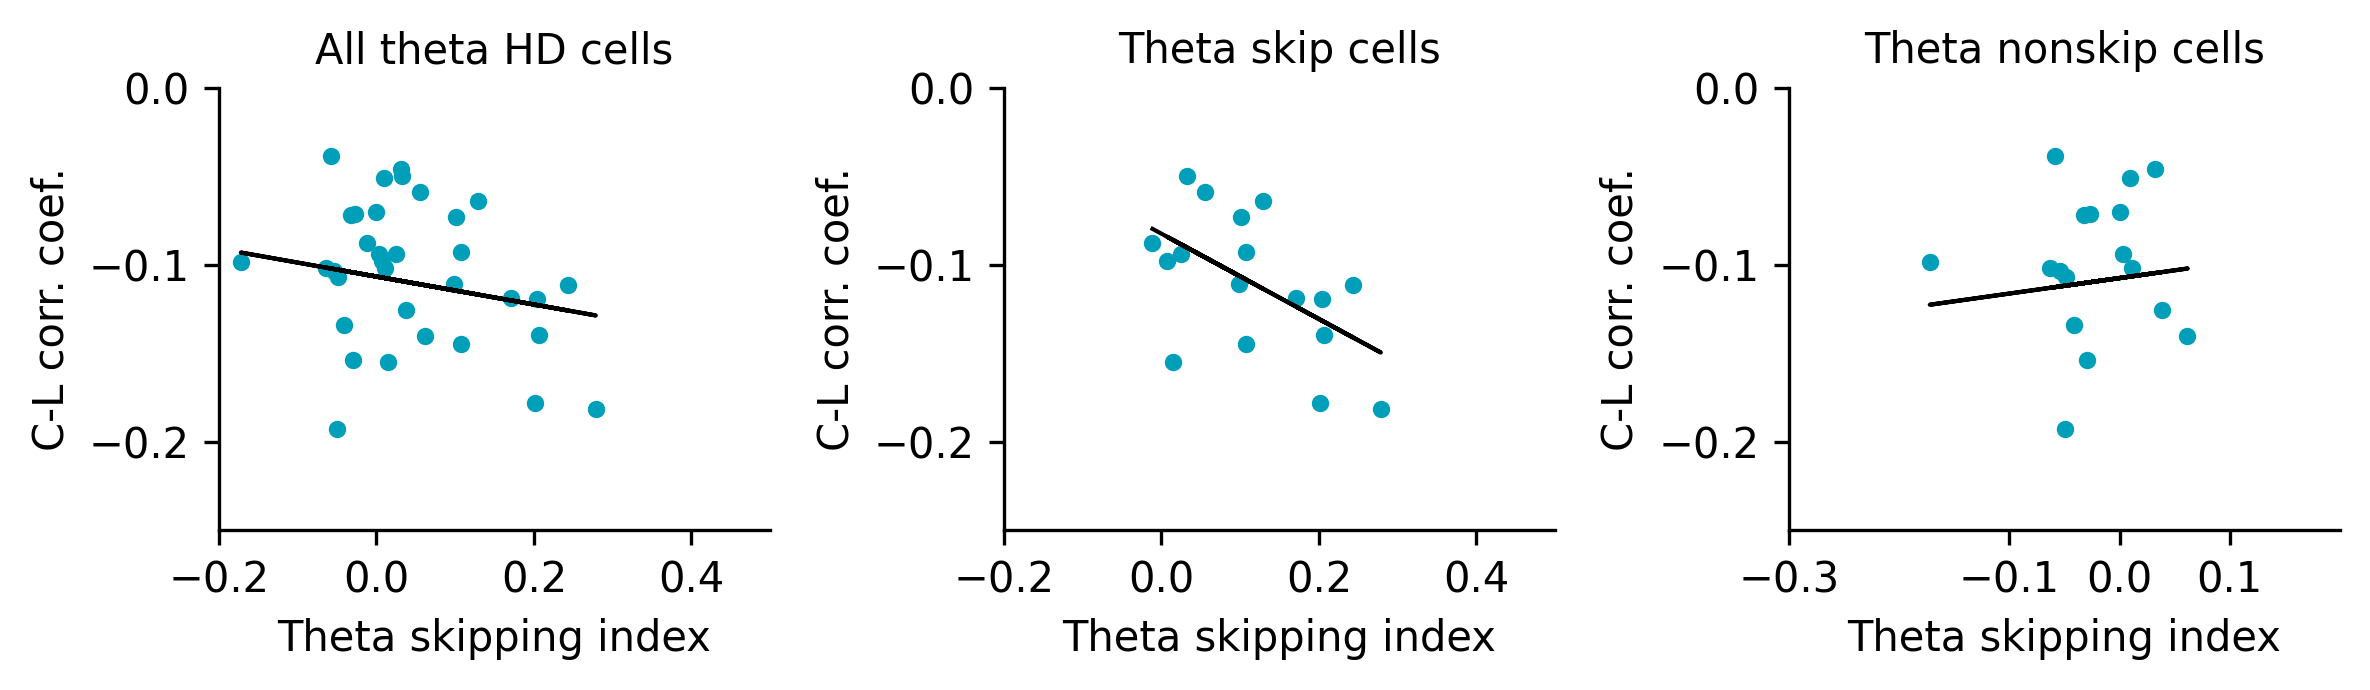

In [6]:
#plot theta_clr against theta_TS for theta_ppp<0.05
fig, axs = plt.subplots(1, 3, figsize=(8, 2.4), dpi=300)
labelsize = 10

ax = axs[0]
indx = np.where((np.array(theta_ppp) < 0.05) & (np.array(theta_clr) < 0))[0]
ax.scatter(np.array(theta_TS)[indx], np.array(theta_clr)[indx], color='#009FB9', label='Theta', s=10)
#add a linear fit line using polyfit
x = np.array(theta_TS)[indx]
y = np.array(theta_clr)[indx]
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.2, 0.5])
ax.set_ylim([-0.25,0.0])
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.set_yticks([-0.2, -0.1, 0])
ax.set_title('All theta HD cells', fontsize=labelsize)

r, p = pearsonr(np.array(theta_TS)[indx], np.array(theta_clr)[indx])
print('r:', r, 'p:', p)

ax = axs[1]
indx = np.where((np.array(theta_skip_ppp) < 0.05) & (np.array(theta_skip_clr) < 0))[0]
ax.scatter(np.array(theta_skip_TS)[indx], np.array(theta_skip_clr)[indx], color='#009FB9', label='Theta skip', s=10)

#add a linear fit line using polyfit
x = np.array(theta_skip_TS)[indx]
y = np.array(theta_skip_clr)[indx]
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.2, 0.5])
ax.set_ylim([-0.25,0.0])
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.set_yticks([-0.2, -0.1, 0])
ax.set_title('Theta skip cells', fontsize=labelsize)

r, p = pearsonr(np.array(theta_skip_TS)[indx], np.array(theta_skip_clr)[indx])
print('r:', r, 'p:', p)

ax = axs[2]
indx = np.where((np.array(theta_nonskip_ppp) < 0.05) & (np.array(theta_nonskip_clr) < 0))[0]
ax.scatter(np.array(theta_nonskip_TS)[indx], np.array(theta_nonskip_clr)[indx], color='#009FB9', label='Theta nonskip', s=10)
#add a linear fit line using polyfit
x = np.array(theta_nonskip_TS)[indx]
y = np.array(theta_nonskip_clr)[indx]
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.3, 0.2])
ax.set_ylim([-0.25,0.0])
ax.set_xticks([-0.3, -0.1, 0, 0.1])
ax.set_yticks([-0.2, -0.1, 0])
ax.set_title('Theta nonskip cells', fontsize=labelsize)

r, p = pearsonr(np.array(theta_nonskip_TS)[indx], np.array(theta_nonskip_clr)[indx])
print('r:', r, 'p:', p)

for ax in axs:
    ax.set_xlabel('Theta skipping index', fontsize=labelsize)
    ax.set_ylabel('C-L corr. coef.', fontsize=labelsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()


r: -0.5428829307519649 p: 0.024330417786070365


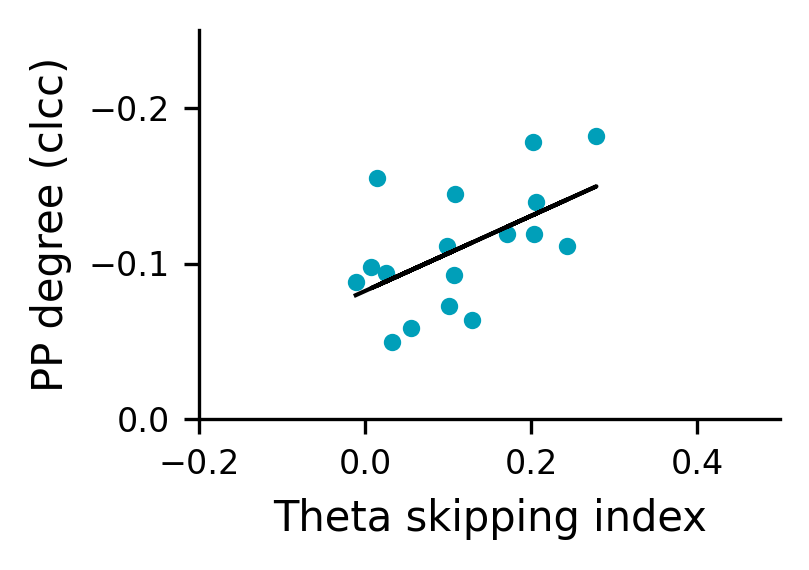

In [7]:
#plot theta_clr against theta_TS for theta_ppp<0.05
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.0), dpi=300)
labelsize = 10 
ticksize = 8

indx = np.where((np.array(theta_skip_ppp) < 0.05) & (np.array(theta_skip_clr) < 0))[0]
ax.scatter(np.array(theta_skip_TS)[indx], np.array(theta_skip_clr)[indx], color='#009FB9', label='Theta skip', s=10)

#add a linear fit line using polyfit
x = np.array(theta_skip_TS)[indx]
y = np.array(theta_skip_clr)[indx]
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.2, 0.5])
ax.set_ylim([-0.25,0.0])
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.set_yticks([-0.2, -0.1, 0])

#invese y 
ax.invert_yaxis()

#set x and y tick size
ax.tick_params(axis='x', which='major', labelsize=ticksize)
ax.tick_params(axis='y', which='major', labelsize=ticksize)

r, p = pearsonr(np.array(theta_skip_TS)[indx], np.array(theta_skip_clr)[indx])
print('r:', r, 'p:', p)

ax.set_ylabel('PP degree (clcc)', fontsize=labelsize)
ax.set_xlabel('Theta skipping index', fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/theta_lowspeed_TS_vs_highspeed_clr.pdf')

In [5]:
 #calculate the mean and std
indx = np.where((np.array(theta_ppp) < 0.05) & (np.array(theta_clr) < 0))[0]
print(np.array(theta_TS)[indx].mean(), np.array(theta_TS)[indx].std())

print(np.array(theta_TS_1)[indx].mean(), np.array(theta_TS_1)[indx].std())



0.0431911254567326 0.09973225866891877
0.0568684217857085 0.10025194711176022


In [6]:
indx = np.where((np.array(theta_skip_ppp) < 0.05) & (np.array(theta_skip_clr) < 0))[0]
print(np.array(theta_skip_TS)[indx].mean(), np.array(theta_skip_TS)[indx].std())

print(np.array(theta_skip_TS_1)[indx].mean(), np.array(theta_skip_TS_1)[indx].std())

0.11607064363393857 0.08647735677629333
0.13035971703521285 0.08075806882081749
